Created on Tue Feb  7 08:03:51 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.5 地域分区

## 3.5.1 样本数据

In [297]:
%load_ext autoreload
%autoreload 2
from usda import datasets as usda_datasets
from usda import data_visualization as usda_vis
from usda import pattern_signature as usda_signature
from usda import geodata_process as usda_geodataProcess
from usda import utils as usda_utils

import mapclassify
import matplotlib.pyplot as plt
import matplotlib
import cc3d
import numpy as np
import math
import itertools
from collections import Counter
import pandas as pd

import math
from toolz import partition

import rasterio as rio
import earthpy.plot as ep
import copy
from rasterio.plot import show
from shapely.geometry import mapping
import rioxarray as rxr
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
size=16
X,_=usda_datasets.generate_categorical_2darray(size=size)
X4=mapclassify.JenksCaspall(X[0], k=4).yb.reshape(size,size)+1

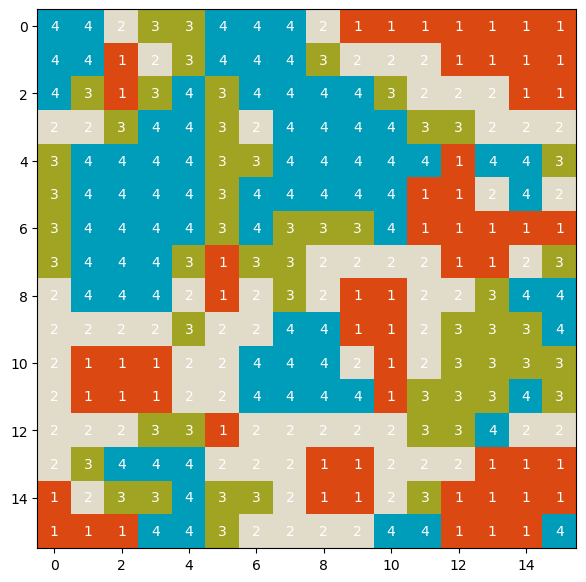

In [39]:
usda_vis.imshow_label2darray(X4,figsize=(7,7),random_seed=29) 

## 3.5.2 模式标记/特征（Pattern Signature）

### 3.5.2.1 连通域标签（connected components labelinga（CCL））

---------- 42


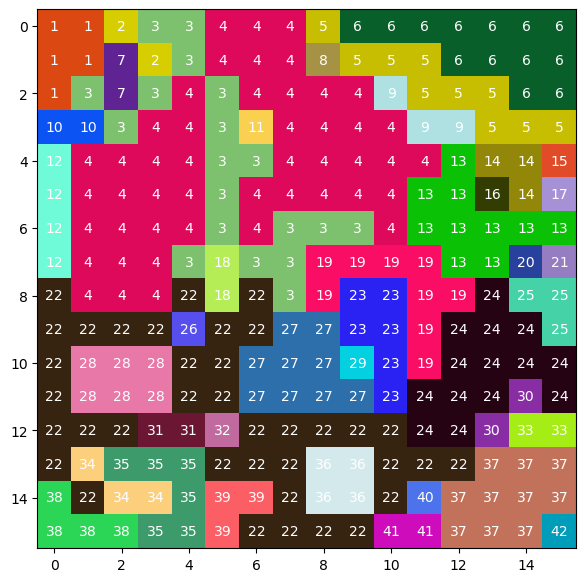

In [40]:
clump_labels,N=cc3d.connected_components(X4,connectivity=8,return_N=True,out_dtype=np.uint64) 
print('-'*10,N)
usda_vis.imshow_label2darray(clump_labels,figsize=(7,7),random_seed=29) 

### 3.5.2.2 类/簇大小 直方图 （class/clump-size histogram）

In [149]:
class_clumpSize_histogram_X4=usda_signature.class_clumpSize_histogram(X4,clump_labels)   
class_clumpSize_histogram_X4

class,1,2,3,4
inds,,,,
1,1,6,3,2
2,9,5,9,8
3,5,4,12,14
4,23,19,23,10
5,19,0,0,0
6,47,0,37,0


### 3.5.2.3  共现关系（Co-occurrence）

In [54]:
class_pairs_frequency=usda_signature.class_co_occurrence(X4)
class_pairs_frequency

,0
"(1, 2)",133.0
"(1, 3)",34.0
"(1, 4)",36.0
"(2, 3)",97.0
"(2, 4)",84.0
"(3, 4)",126.0
"(1, 1)",100.0
"(2, 2)",87.0
"(3, 3)",67.0
"(4, 4)",166.0


### 3.5.2.4  层级分解（Hierarchical decomposition）

In [43]:
class_hierarchical_decomposition=usda_signature.class_decomposition(X4)    
class_hierarchical_decomposition

1     2     3   4
2 1  36.0  28.0  31.0  27
  2  21.0  29.0  29.0  25
  3   7.0   7.0   4.0  12
4 1   9.0   6.0   9.0   7
  2   5.0  10.0   6.0   7
  3   2.0   0.0   1.0   2
8 1   2.0   1.0   3.0   2
  2   2.0   3.0   1.0   1
  3   0.0   0.0   0.0   1

## 3.5.3 距离度量（Distance meatrics）

> from scipy.spatial import distance as ssd

* 比对样本数据

In [44]:
size=16
X_4comparison,_=usda_datasets.generate_categorical_2darray(size=size)
X4_4comparison=mapclassify.JenksCaspall(X_4comparison[0], k=4).yb.reshape(size,size)+1

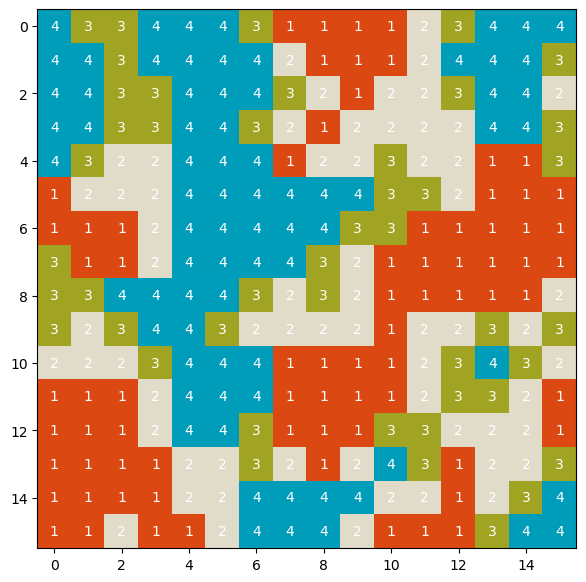

In [45]:
usda_vis.imshow_label2darray(X4_4comparison,figsize=(7,7),random_seed=29) 

In [151]:
clump_labels_4comparison,_=cc3d.connected_components(X4_4comparison,connectivity=8,return_N=True,out_dtype=np.uint64) 
class_clumpSize_histogram_X4_4comparison=usda_signature.class_clumpSize_histogram(X4_4comparison,clump_labels_4comparison) 
class_pairs_frequency_4comparison=usda_signature.class_co_occurrence(X4_4comparison)
class_hierarchical_decomposition_4comparison=usda_signature.class_decomposition(X4_4comparison)   

从直方图（histogram）到概率密度函数（probability density function, pdf）

* 类/簇大小距离计算

In [47]:
print(class_clumpSize_histogram_X4.values.sum())
print(class_clumpSize_histogram_X4_4comparison.values.sum())

256
256


In [152]:
class_clumpSize_X_pdf=class_clumpSize_histogram_X4/class_clumpSize_histogram_X4.values.sum()
print(class_clumpSize_X_pdf.values.sum())
class_clumpSize_X_pdf

1.0


class,1,2,3,4
inds,,,,
1,0.003906,0.023438,0.011719,0.007812
2,0.035156,0.019531,0.035156,0.031250
3,0.019531,0.015625,0.046875,0.054688
4,0.089844,0.074219,0.089844,0.039062
5,0.074219,0.000000,0.000000,0.000000
6,0.183594,0.000000,0.144531,0.000000


In [153]:
class_clumpSize_X4_4comparison_pdf=class_clumpSize_histogram_X4_4comparison/class_clumpSize_histogram_X4_4comparison.values.sum()
print(class_clumpSize_X4_4comparison_pdf.values.sum())
class_clumpSize_X4_4comparison_pdf

1.0


class,1,2,3,4
inds,,,,
1,0.003906,0.015625,0.007812,0.003906
2,0.000000,0.015625,0.023438,0.023438
3,0.000000,0.054688,0.074219,0.035156
4,0.101562,0.039062,0.132812,0.031250
5,0.062500,0.000000,0.070312,0.000000
6,0.171875,0.000000,0.132812,0.000000


In [52]:
class_clumpSize_pdf_shannon=usda_signature.Distances(class_clumpSize_X_pdf.to_numpy().flatten(),class_clumpSize_X4_4comparison_pdf.to_numpy().flatten())
class_clumpSize_pdf_shannon.shannon()

{'Kull-Leiber': 2.4015089667570453,
 'Jeffreys': 5.507004118159568,
 'Kdivergence': 0.06257071737333801,
 'Topsoe': 0.11864627590431427,
 'Jensen-Shan': 0.059323137952157136,
 'Jensen-Diff': 0.05932313795215706}

* 共现关系距离计算

In [58]:
class_pairs_frequency

,0
"(1, 2)",133.0
"(1, 3)",34.0
"(1, 4)",36.0
"(2, 3)",97.0
"(2, 4)",84.0
"(3, 4)",126.0
"(1, 1)",100.0
"(2, 2)",87.0
"(3, 3)",67.0
"(4, 4)",166.0


In [65]:
print(class_pairs_frequency.values.sum())
print(class_pairs_frequency_4comparison.values.sum())

930.0
930.0


In [66]:
class_pairs_frequency_pdf=class_pairs_frequency/class_pairs_frequency.values.sum()
class_pairs_frequency_pdf

,0
"(1, 2)",0.143011
"(1, 3)",0.036559
"(1, 4)",0.038710
"(2, 3)",0.104301
"(2, 4)",0.090323
"(3, 4)",0.135484
"(1, 1)",0.107527
"(2, 2)",0.093548
"(3, 3)",0.072043
"(4, 4)",0.178495


In [67]:
class_pairs_frequency_4comparison_pdf=class_pairs_frequency_4comparison/class_pairs_frequency_4comparison.values.sum() 
class_pairs_frequency_4comparison_pdf

,0
"(1, 2)",0.138710
"(1, 3)",0.044086
"(1, 4)",0.025806
"(2, 3)",0.100000
"(2, 4)",0.079570
"(3, 4)",0.104301
"(1, 1)",0.181720
"(2, 2)",0.094624
"(3, 3)",0.048387
"(4, 4)",0.182796


In [68]:
class_pairs_pdf_wave_hedges=usda_signature.Distances(class_pairs_frequency_pdf.to_numpy().flatten(),class_pairs_frequency_4comparison_pdf.to_numpy().flatten())
class_pairs_pdf_wave_hedges.intersection()

{'Intersection': 0.08709677419354839,
 'Wave Hedges': 1.696118971980947,
 'Czekanowski': 0.08709677419354839,
 'Motyka': 0.5435483870967742,
 'Ruzicka': 0.1602373887240357,
 'Tanimoto': 0.1602373887240356}

* 层级分解距离计算

In [69]:
print([class_hierarchical_decomposition.loc[[idx]].values.sum() for idx in [2,4,8]])

[256.0, 64.0, 16.0]


In [70]:
class_hierarchical_decomposition_pdf=class_hierarchical_decomposition/class_hierarchical_decomposition.values.sum()
class_hierarchical_decomposition_pdf

1         2         3         4
2 1  0.107143  0.083333  0.092262  0.080357
  2  0.062500  0.086310  0.086310  0.074405
  3  0.020833  0.020833  0.011905  0.035714
4 1  0.026786  0.017857  0.026786  0.020833
  2  0.014881  0.029762  0.017857  0.020833
  3  0.005952  0.000000  0.002976  0.005952
8 1  0.005952  0.002976  0.008929  0.005952
  2  0.005952  0.008929  0.002976  0.002976
  3  0.000000  0.000000  0.000000  0.002976

In [71]:
class_hierarchical_decomposition_4comparison_pdf=class_hierarchical_decomposition_4comparison/class_hierarchical_decomposition_4comparison.values.sum()
class_hierarchical_decomposition_4comparison_pdf

1         2         3         4
2 1  0.092262  0.086310  0.101190  0.107143
  2  0.059524  0.086310  0.074405  0.035714
  3  0.038690  0.017857  0.014881  0.047619
4 1  0.023810  0.020833  0.032738  0.026786
  2  0.014881  0.026786  0.014881  0.005952
  3  0.008929  0.000000  0.000000  0.014881
8 1  0.002976  0.002976  0.011905  0.005952
  2  0.008929  0.008929  0.000000  0.002976
  3  0.000000  0.000000  0.000000  0.002976

In [73]:
class_hierarchical_decomposition_pdf_Jaccard=usda_signature.Distances(class_hierarchical_decomposition_pdf.to_numpy().flatten(),class_hierarchical_decomposition_4comparison_pdf.to_numpy().flatten())
class_hierarchical_decomposition_pdf_Jaccard.inner()

{'Inner Product': 0.937358276643991,
 'Harmonic Mean': 0.02519574508227085,
 'Cosine': 0.02803738317757043,
 'Jaccard': 0.05454545454545454,
 'Dice': 0.0280373831775701}

In [81]:
nlcd_2019_lc_fn=r'E:\data\NLCD_landcover_2019_release_all_files_20210604\nlcd_2019_land_cover_l48_20210604\nlcd_2019_land_cover_l48_20210604.img'

with rio.open(nlcd_2019_lc_fn) as src:    
    landuse_array=src.read()
    transform=src.transform
    epsg_nlcd=src.crs
    
print(epsg_nlcd)

PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [82]:
pt_leftBottom=[-122.51764,37.46971]
pt_rightTop=[-122.06587,37.94047] 
pt_leftBottom_pj=usda_geodataProcess.pt_coordi_transform(4326,epsg_nlcd,pt_leftBottom)
pt_rightTop_pj=usda_geodataProcess.pt_coordi_transform(4326,epsg_nlcd,pt_rightTop)

In [83]:
cell_size=2000
quadrats_gdf=usda_geodataProcess.rec_quadrats_gdf(pt_leftBottom_pj,pt_rightTop_pj,cell_size,cell_size,crs=epsg_nlcd)
quadrats_gdf['coords']=quadrats_gdf['geometry'].apply(lambda x: x.representative_point().coords[:][0])
quadrats_gdf

,geometry,coords
0,"POLYGON ((-2291093.439 1925411.064, -2293093.4...","(-2292093.4390484886, 1926411.0636174935)"
1,"POLYGON ((-2291093.439 1927411.064, -2293093.4...","(-2292093.4390484886, 1928411.0636174935)"
2,"POLYGON ((-2291093.439 1929411.064, -2293093.4...","(-2292093.4390484886, 1930411.0636174935)"
3,"POLYGON ((-2291093.439 1931411.064, -2293093.4...","(-2292093.4390484886, 1932411.0636174935)"
4,"POLYGON ((-2291093.439 1933411.064, -2293093.4...","(-2292093.4390484886, 1934411.0636174935)"
...,...,...
489,"POLYGON ((-2241093.439 1953411.064, -2243093.4...","(-2242093.4390484886, 1954411.0636174935)"
490,"POLYGON ((-2241093.439 1955411.064, -2243093.4...","(-2242093.4390484886, 1956411.0636174935)"
491,"POLYGON ((-2241093.439 1957411.064, -2243093.4...","(-2242093.4390484886, 1958411.0636174935)"
492,"POLYGON ((-2241093.439 1959411.064, -2243093.4...","(-2242093.4390484886, 1960411.0636174935)"


In [84]:
lu,transform,ras_meta=usda_geodataProcess.rio_read_subset(nlcd_2019_lc_fn,[pt_leftBottom_pj,pt_rightTop_pj])  

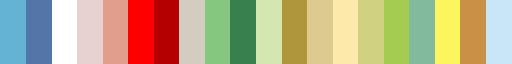

In [85]:
nlcd_class_idNcolor={
    '0':[0,"#64b3d5"],
    'Open_Water':[11,"#5475a8"],
    'Perennial_IceSnow':[12,"#ffffff"],
    'Developed_Open_Space':[21,"#e8d1d1"],
    'Developed_Low_Intensity':[22,"#e29e8c"],
    'Developed_Medium_Intensity':[23,"#ff0000"],
    'Developed_High_Intensity':[24,"#b50000"],
    'Barren_Land_RockSandClay) ':[31,"#d2cdc0"],
    'Deciduous_Forest':[41,'#85c77e'],
    'Evergreen_Forest':[42,"#38814e"],
    'Mixed Fores':[43,"#d4e7b0"],
    'Dwarf_Scrub':[51,"#af963c"],
    'Shrub_Scrub':[52,"#dcca8f"],
    'Grassland_Herbaceous':[71,"#fde9aa"],
    'Sedge_Herbaceous':[72,"#d1d182"],
    'Lichens':[73,"#a3cc51"],
    'Moss':[74,"#82ba9e"],
    'Pasture_Hay':[81,"#fbf65d"],
    'Cultivated_Crops':[82,"#ca9146"],
    'Woody_Wetlands':[90,"#c8e6f8"],
    'Emergent_Herbaceous_Wetlands':[95,"#64b3d5"],    
    }

nlcd_class_color={v[0]:v[1] for v in nlcd_class_idNcolor.values()}
cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(nlcd_class_color.keys()),list(nlcd_class_color.values()),extend='max')
cmap_LC

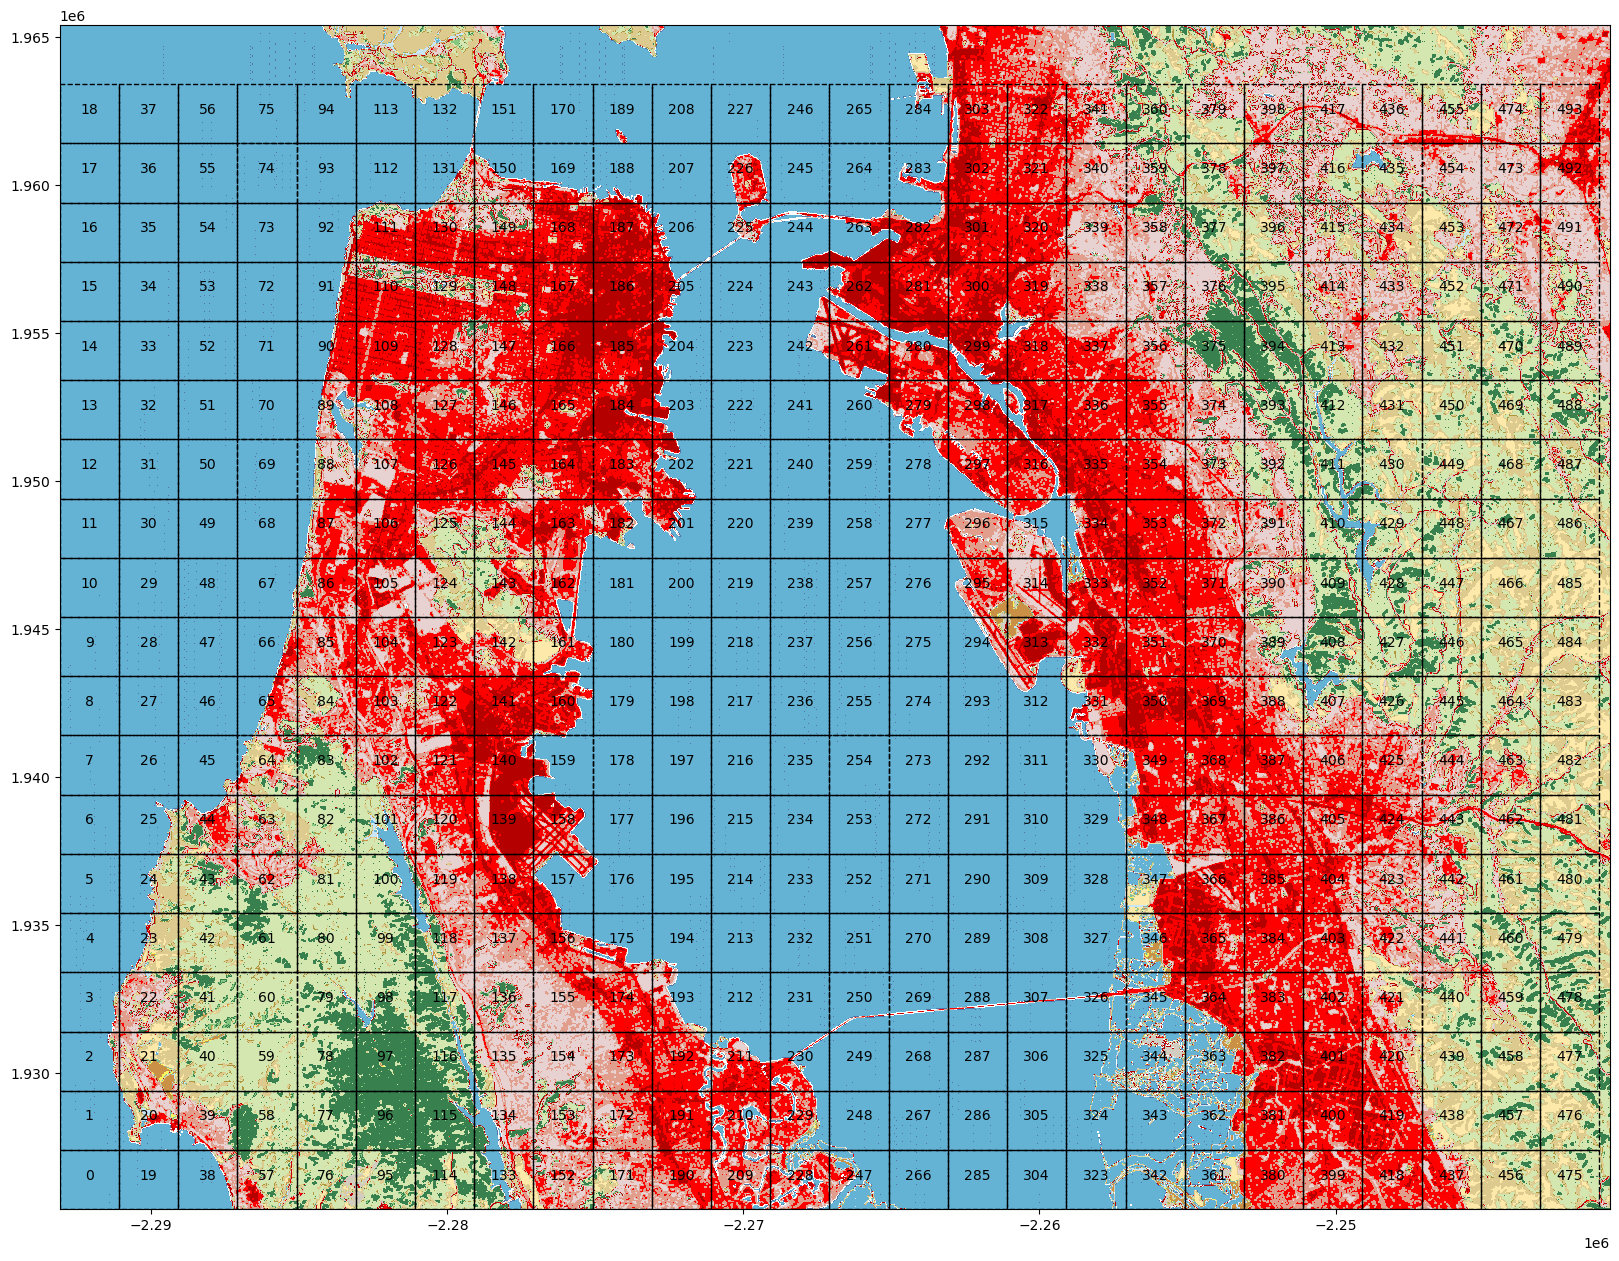

In [334]:
f, ax=plt.subplots(figsize=(20,20))
show(lu,ax=ax,transform=transform,cmap=cmap_LC,norm=norm)
quadrats_gdf.plot(color='none',edgecolor='k',linewidth=1,ax=ax,linestyle='--')
for idx, row in quadrats_gdf.iterrows():    
    ax.annotate(text=idx, xy=row['coords'], horizontalalignment='center')
plt.show()

In [ ]:
san_francisco_nlcd_2019_lc_fn=r'E:\data\NLCD_landcover_2019_release_all_files_20210604\clipped\san_francisco_nlcd_2019_lc.tif'

ras_meta_=copy.deepcopy(ras_meta)
ras_meta_.update(   
        compress='lzw',
        )  
with rio.open(san_francisco_nlcd_2019_lc_fn,'w',**ras_meta_) as dst:
    dst.write(lu)

In [ ]:
san_francisco_nlcd_2019_lc_fn=r'E:\data\NLCD_landcover_2019_release_all_files_20210604\clipped\san_francisco_nlcd_2019_lc.tif'
san_francisco_nlcd_2019_lc=rxr.open_rasterio(san_francisco_nlcd_2019_lc_fn,masked=True).squeeze()

In [ ]:
san_francisco_nlcd_2019_lc.rio.crs

In [16]:
pt_leftBottom=[-122.51764,37.46971]
pt_rightTop=[-122.06587,37.94047] 
pt_leftBottom_pj=usda_geodataProcess.pt_coordi_transform(4326,san_francisco_nlcd_2019_lc.rio.crs,pt_leftBottom)
pt_rightTop_pj=usda_geodataProcess.pt_coordi_transform(4326,san_francisco_nlcd_2019_lc.rio.crs,pt_rightTop)

cell_size=2000
quadrats_gdf=usda_geodataProcess.rec_quadrats_gdf(pt_leftBottom_pj,pt_rightTop_pj,cell_size,cell_size,crs=san_francisco_nlcd_2019_lc.rio.crs)
quadrats_gdf['coords']=quadrats_gdf['geometry'].apply(lambda x: x.representative_point().coords[:][0])
quadrats_gdf

,geometry,coords
0,"POLYGON ((-2291093.439 1925411.064, -2293093.4...","(-2292093.4390484886, 1926411.0636174935)"
1,"POLYGON ((-2291093.439 1927411.064, -2293093.4...","(-2292093.4390484886, 1928411.0636174935)"
2,"POLYGON ((-2291093.439 1929411.064, -2293093.4...","(-2292093.4390484886, 1930411.0636174935)"
3,"POLYGON ((-2291093.439 1931411.064, -2293093.4...","(-2292093.4390484886, 1932411.0636174935)"
4,"POLYGON ((-2291093.439 1933411.064, -2293093.4...","(-2292093.4390484886, 1934411.0636174935)"
...,...,...
489,"POLYGON ((-2241093.439 1953411.064, -2243093.4...","(-2242093.4390484886, 1954411.0636174935)"
490,"POLYGON ((-2241093.439 1955411.064, -2243093.4...","(-2242093.4390484886, 1956411.0636174935)"
491,"POLYGON ((-2241093.439 1957411.064, -2243093.4...","(-2242093.4390484886, 1958411.0636174935)"
492,"POLYGON ((-2241093.439 1959411.064, -2243093.4...","(-2242093.4390484886, 1960411.0636174935)"


In [255]:
scene_idx_lst=[63,80,81,84,96,97,109,186,315,409]
scenes={k:san_francisco_nlcd_2019_lc.rio.clip([quadrats_gdf.geometry.apply(mapping).iloc[k]],quadrats_gdf.crs) for k in scene_idx_lst}

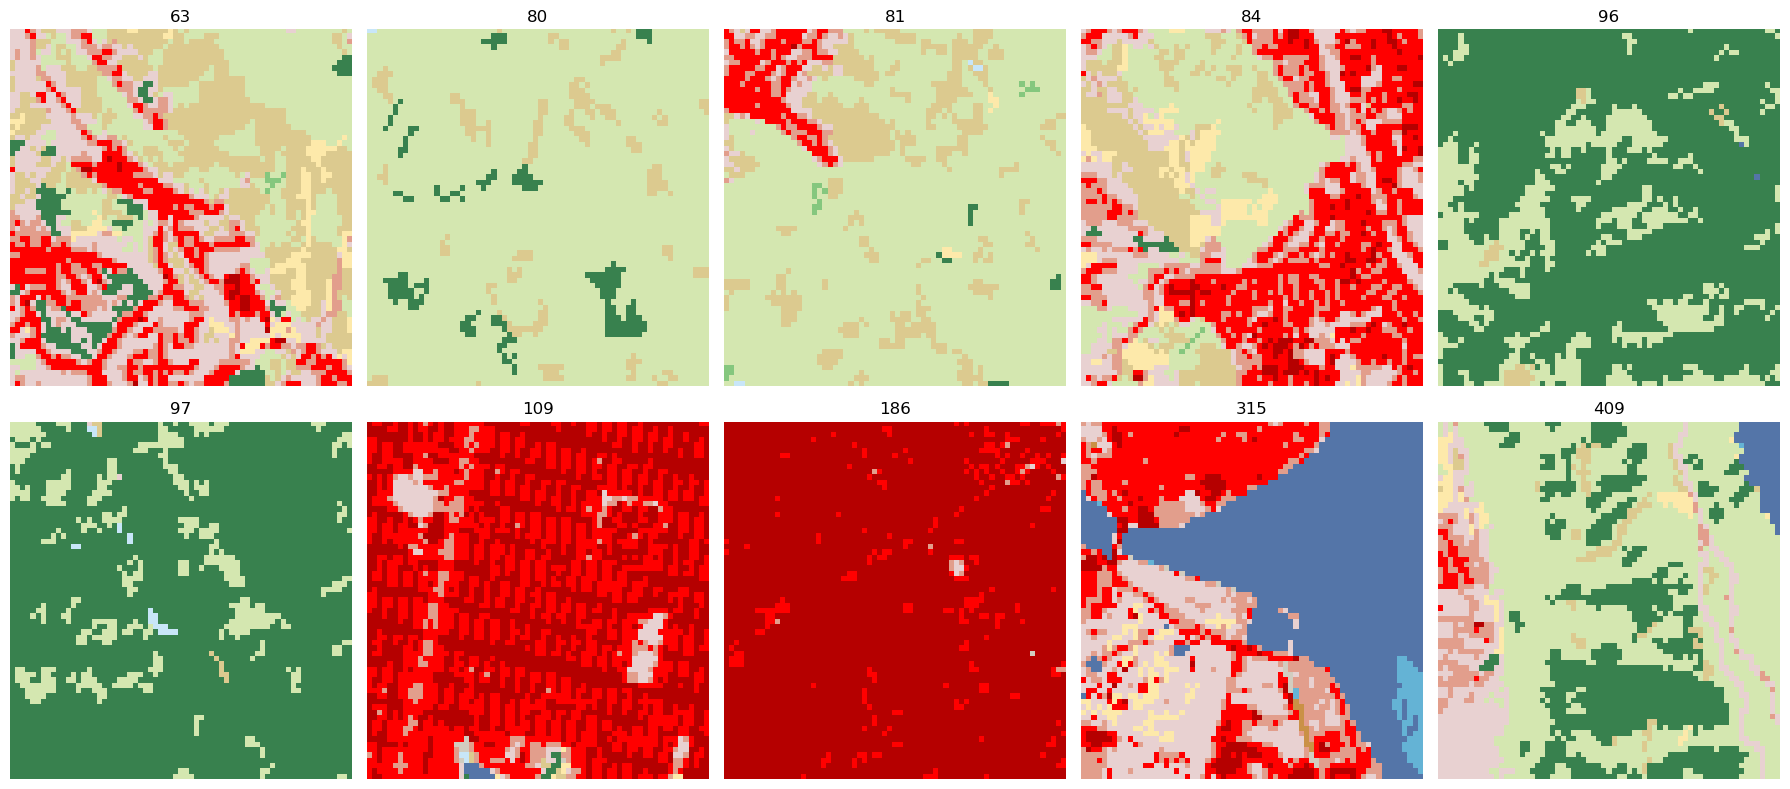

In [97]:
fig, axs=plt.subplots(nrows=2, ncols=5, figsize=(9*2, 4*2),subplot_kw={'xticks': [], 'yticks': []})
for ax, (idx,scene) in zip(axs.flat, scenes.items()):
    scene.plot.imshow(add_colorbar=False,cmap=cmap_LC,norm=norm,ax=ax)
    ax.set_title(idx)
    ax.set_axis_off()
                 
plt.tight_layout()
plt.show()                 

In [256]:
pattern_distance_df=usda_signature.signature2distance_integrating(scenes,signatures_lst=['class_hierarchical_decomposition','class_pairs_frequency','class_clumpSize'])    
pattern_distance_df

class_hierarchical_decomposition  class_pairs_frequency  \
63  80                           0.818697              36.114617   
    81                           0.212229              32.686012   
    84                           0.023534              19.777420   
    96                           0.850479              37.042946   
    97                           0.803605              40.512433   
    109                          0.593157              54.352800   
    186                          0.796919              36.825706   
    315                          0.645925              54.150345   
    409                          0.396148              35.773141   
80  81                           0.632294              28.217521   
    84                           0.788244              37.246134   
    96                           0.777978               8.872845   
    97                           0.647031              12.049431   
    109                          0.693220              51.241613   
    186                          1.000000              19.000000   
    315                          1.000000              49.000000   
    409                          0.807399              35.011363   
81  84                           0.227968              34.150054   
    96                           0.891942              32.640539   
    97                           0.715356              32.765645   
    109                          0.477403              51.604482   
    186                          0.755293              31.929292   
    315                          0.660390              60.627205   
    409                          0.406146              37.141794   
84  96                           0.827232              37.749536   
    97                           0.771575              41.226368   
    109                          0.554190              52.827141   
    186                          0.814807              36.341972   
    315                          0.671761              53.718118   
    409                          0.412026              37.049261   
96  97                           0.572186              12.929291   
    109                          0.764689              51.529262   
    186                          1.000000              19.000000   
    315                          0.941917              49.000000   
    409                          0.706103              31.546109   
97  109                          0.702579              50.532680   
    186                          0.874830              24.000000   
    315                          0.935202              54.000000   
    409                          0.786699              37.969910   
109 186                          0.663647              45.767654   
    315                          0.597354              56.128743   
    409                          0.494970              50.475681   
186 315                          0.657728              38.582079   
    409                          0.763090              34.200132   
315 409                          0.442134              55.589732   

         class_clumpSize  
63  80          0.654475  
    81          0.497414  
    84          0.123408  
    96          0.655214  
    97          0.639216  
    109         0.375302  
    186         0.653542  
    315         0.451318  
    409         0.483825  
80  81          0.651995  
    84          0.678948  
    96          0.682383  
    97          0.681453  
    109         0.689470  
    186         0.693147  
    315         0.693147  
    409         0.662998  
81  84          0.607962  
    96          0.685900  
    97          0.112715  
    109         0.621676  
    186         0.683971  
    315         0.637958  
    409         0.637785  
84  96          0.666897  
    97          0.651282  
    109         0.367793  
    186         0.652068  
    315         0.462117  
    409         0.511255  
96  97          0.636653  
    109         

## 3.5.4 地理处理模块（Geoprocessing modules）

### 3.5.4.1 模式级聚——距离矩阵与层级聚类（distance matrix and hierarchical clustering）

In [257]:
nlcd_decomposition_matrix=usda_utils.xy_to_matrix(pattern_distance_df[['class_hierarchical_decomposition']].reset_index())
nlcd_decomposition_matrix

level_0,63,80,81,84,96,97,109,186,315
level_0,,,,,,,,,
63,0.818697,0.212229,0.023534,0.850479,0.803605,0.593157,0.796919,0.645925,0.396148
80,0.212229,0.632294,0.788244,0.777978,0.647031,0.693220,1.000000,1.000000,0.807399
81,0.023534,0.788244,0.227968,0.891942,0.715356,0.477403,0.755293,0.660390,0.406146
84,0.850479,0.777978,0.891942,0.827232,0.771575,0.554190,0.814807,0.671761,0.412026
96,0.803605,0.647031,0.715356,0.771575,0.572186,0.764689,1.000000,0.941917,0.706103
97,0.593157,0.693220,0.477403,0.554190,0.764689,0.702579,0.874830,0.935202,0.786699
109,0.796919,1.000000,0.755293,0.814807,1.000000,0.874830,0.663647,0.597354,0.494970
186,0.645925,1.000000,0.660390,0.671761,0.941917,0.935202,0.597354,0.657728,0.763090
315,0.396148,0.807399,0.406146,0.412026,0.706103,0.786699,0.494970,0.763090,0.442134


In [258]:
Z=linkage(nlcd_decomposition_matrix, method='single',) # optimal_ordering=True;  [idx1, idx2, dist, sample_count]
Z

array([[ 6.        ,  7.        ,  0.37311413,  2.        ],
       [ 4.        ,  5.        ,  0.46197665,  2.        ],
       [ 3.        ,  9.        ,  0.51111962,  3.        ],
       [ 1.        , 10.        ,  0.57423549,  3.        ],
       [11.        , 12.        ,  0.57571898,  6.        ],
       [ 8.        , 13.        ,  0.61667451,  7.        ],
       [ 2.        , 14.        ,  0.75936557,  8.        ],
       [ 0.        , 15.        ,  0.9120165 ,  9.        ]])

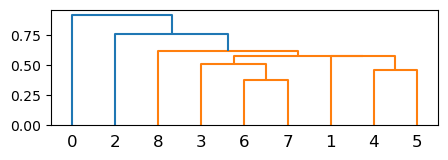

In [244]:
fig=plt.figure(figsize=(5, 1.5))
dn=dendrogram(Z)
plt.show()

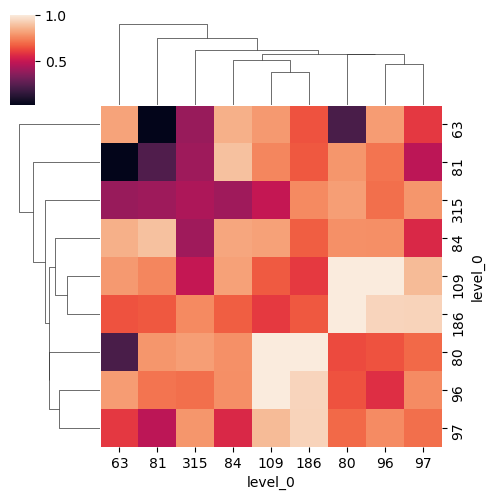

In [245]:
sns.clustermap(nlcd_decomposition_matrix,method='single',figsize=(5,5));

In [259]:
c, coph_dists=cophenet(Z, pdist(nlcd_decomposition_matrix))
print(c)

0.8090297742076558


In [450]:
scene_idx_lst_2=list(range(285,494)) # 228
scenes_2={k:san_francisco_nlcd_2019_lc.rio.clip([quadrats_gdf.geometry.apply(mapping).iloc[k]],quadrats_gdf.crs) for k in scene_idx_lst_2}

In [451]:
pattern_distance_df_2=usda_signature.signature2distance_integrating(scenes_2,signatures_lst=['class_hierarchical_decomposition','class_pairs_frequency','class_clumpSize'])    
pattern_distance_df_2

class_hierarchical_decomposition  class_pairs_frequency  \
285 286                          0.000000               0.000000   
    287                          0.000000               0.000000   
    288                          0.808186              12.038733   
    289                          0.000000               0.000000   
    290                          0.000000               0.000000   
...                                   ...                    ...   
490 492                          0.485143              27.948164   
    493                          0.529574              25.737011   
491 492                          0.224449              22.373891   
    493                          0.219774              18.494940   
492 493                          0.291351              14.616090   

         class_clumpSize  
285 286         0.000000  
    287         0.000000  
    288         0.693147  
    289         0.000000  
    290         0.000000  
...                  ...  
490 492         0.289413  
    493         0.101509  
491 492         0.144817  
    493         0.215617  
492 493         0.256811  

[21736 rows x 3 columns]

In [452]:
from sklearn import preprocessing
pattern_distance_df_2_copy=pattern_distance_df_2.copy(deep=True)
min_max_scaler=preprocessing.MinMaxScaler()
class_pairs_frequency_scaled=min_max_scaler.fit_transform(pattern_distance_df_2_copy['class_pairs_frequency'].values.reshape(-1, 1))

pattern_distance_df_2_copy['class_pairs_frequency']=class_pairs_frequency_scaled
pattern_distance_df_2_copy

class_hierarchical_decomposition  class_pairs_frequency  \
285 286                          0.000000               0.000000   
    287                          0.000000               0.000000   
    288                          0.808186               0.155034   
    289                          0.000000               0.000000   
    290                          0.000000               0.000000   
...                                   ...                    ...   
490 492                          0.485143               0.359915   
    493                          0.529574               0.331440   
491 492                          0.224449               0.288130   
    493                          0.219774               0.238177   
492 493                          0.291351               0.188225   

         class_clumpSize  
285 286         0.000000  
    287         0.000000  
    288         0.693147  
    289         0.000000  
    290         0.000000  
...                  ...  
490 492         0.289413  
    493         0.101509  
491 492         0.144817  
    493         0.215617  
492 493         0.256811  

[21736 rows x 3 columns]

In [453]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1)
pca.fit(pattern_distance_df_2_copy.values)
pattern_distance_pca=pca.transform(pattern_distance_df_2_copy.values)
pattern_distance_df_2_copy['pca']=pattern_distance_pca
pattern_distance_df_2_copy

class_hierarchical_decomposition  class_pairs_frequency  \
285 286                          0.000000               0.000000   
    287                          0.000000               0.000000   
    288                          0.808186               0.155034   
    289                          0.000000               0.000000   
    290                          0.000000               0.000000   
...                                   ...                    ...   
490 492                          0.485143               0.359915   
    493                          0.529574               0.331440   
491 492                          0.224449               0.288130   
    493                          0.219774               0.238177   
492 493                          0.291351               0.188225   

         class_clumpSize       pca  
285 286         0.000000  0.834949  
    287         0.000000  0.834949  
    288         0.693147 -0.215389  
    289         0.000000  0.834949  
    290         0.000000  0.834949  
...                  ...       ...  
490 492         0.289413  0.232925  
    493         0.101509  0.285184  
491 492         0.144817  0.537287  
    493         0.215617  0.514025  
492 493         0.256811  0.437794  

[21736 rows x 4 columns]

In [454]:
nlcd_decomposition_matrix_2=usda_utils.xy_to_matrix(pattern_distance_df_2_copy[['class_hierarchical_decomposition']].reset_index())
nlcd_decomposition_matrix_2

level_0,285,286,287,288,289,290,291,292,293,294,...,483,484,485,486,487,488,489,490,491,492
level_0,,,,,,,,,,,,,,,,,,,,,
285,0.000000,0.000000,0.808186,0.000000,0.000000,0.000000,0.000000,0.000000,0.908374,0.972271,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
286,0.000000,0.000000,0.808186,0.000000,0.000000,0.000000,0.000000,0.000000,0.908374,0.972271,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
287,0.808186,0.808186,0.808186,0.000000,0.000000,0.000000,0.000000,0.000000,0.908374,0.972271,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
288,0.000000,0.000000,0.000000,0.808186,0.808186,0.808186,0.808186,0.808186,0.446697,0.675142,...,0.669630,0.407547,0.662429,0.520603,0.761273,0.746740,0.655077,0.739468,0.772773,0.698449
289,0.000000,0.000000,0.000000,0.808186,0.000000,0.000000,0.000000,0.000000,0.908374,0.972271,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,1.000000,1.000000,1.000000,0.746740,1.000000,1.000000,1.000000,1.000000,1.000000,0.804177,...,0.536790,0.403661,0.560220,0.358561,0.326089,0.326760,0.402707,0.665262,0.615784,0.690261
489,1.000000,1.000000,1.000000,0.655077,1.000000,1.000000,1.000000,1.000000,1.000000,0.726361,...,0.548839,0.417059,0.377751,0.400858,0.122858,0.402707,0.318219,0.580086,0.607715,0.682560
490,1.000000,1.000000,1.000000,0.739468,1.000000,1.000000,1.000000,1.000000,1.000000,0.656678,...,0.747341,0.655417,0.461184,0.655918,0.468929,0.665262,0.580086,0.343363,0.485143,0.529574


C:\Users\richi\anaconda3\envs\gpd\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


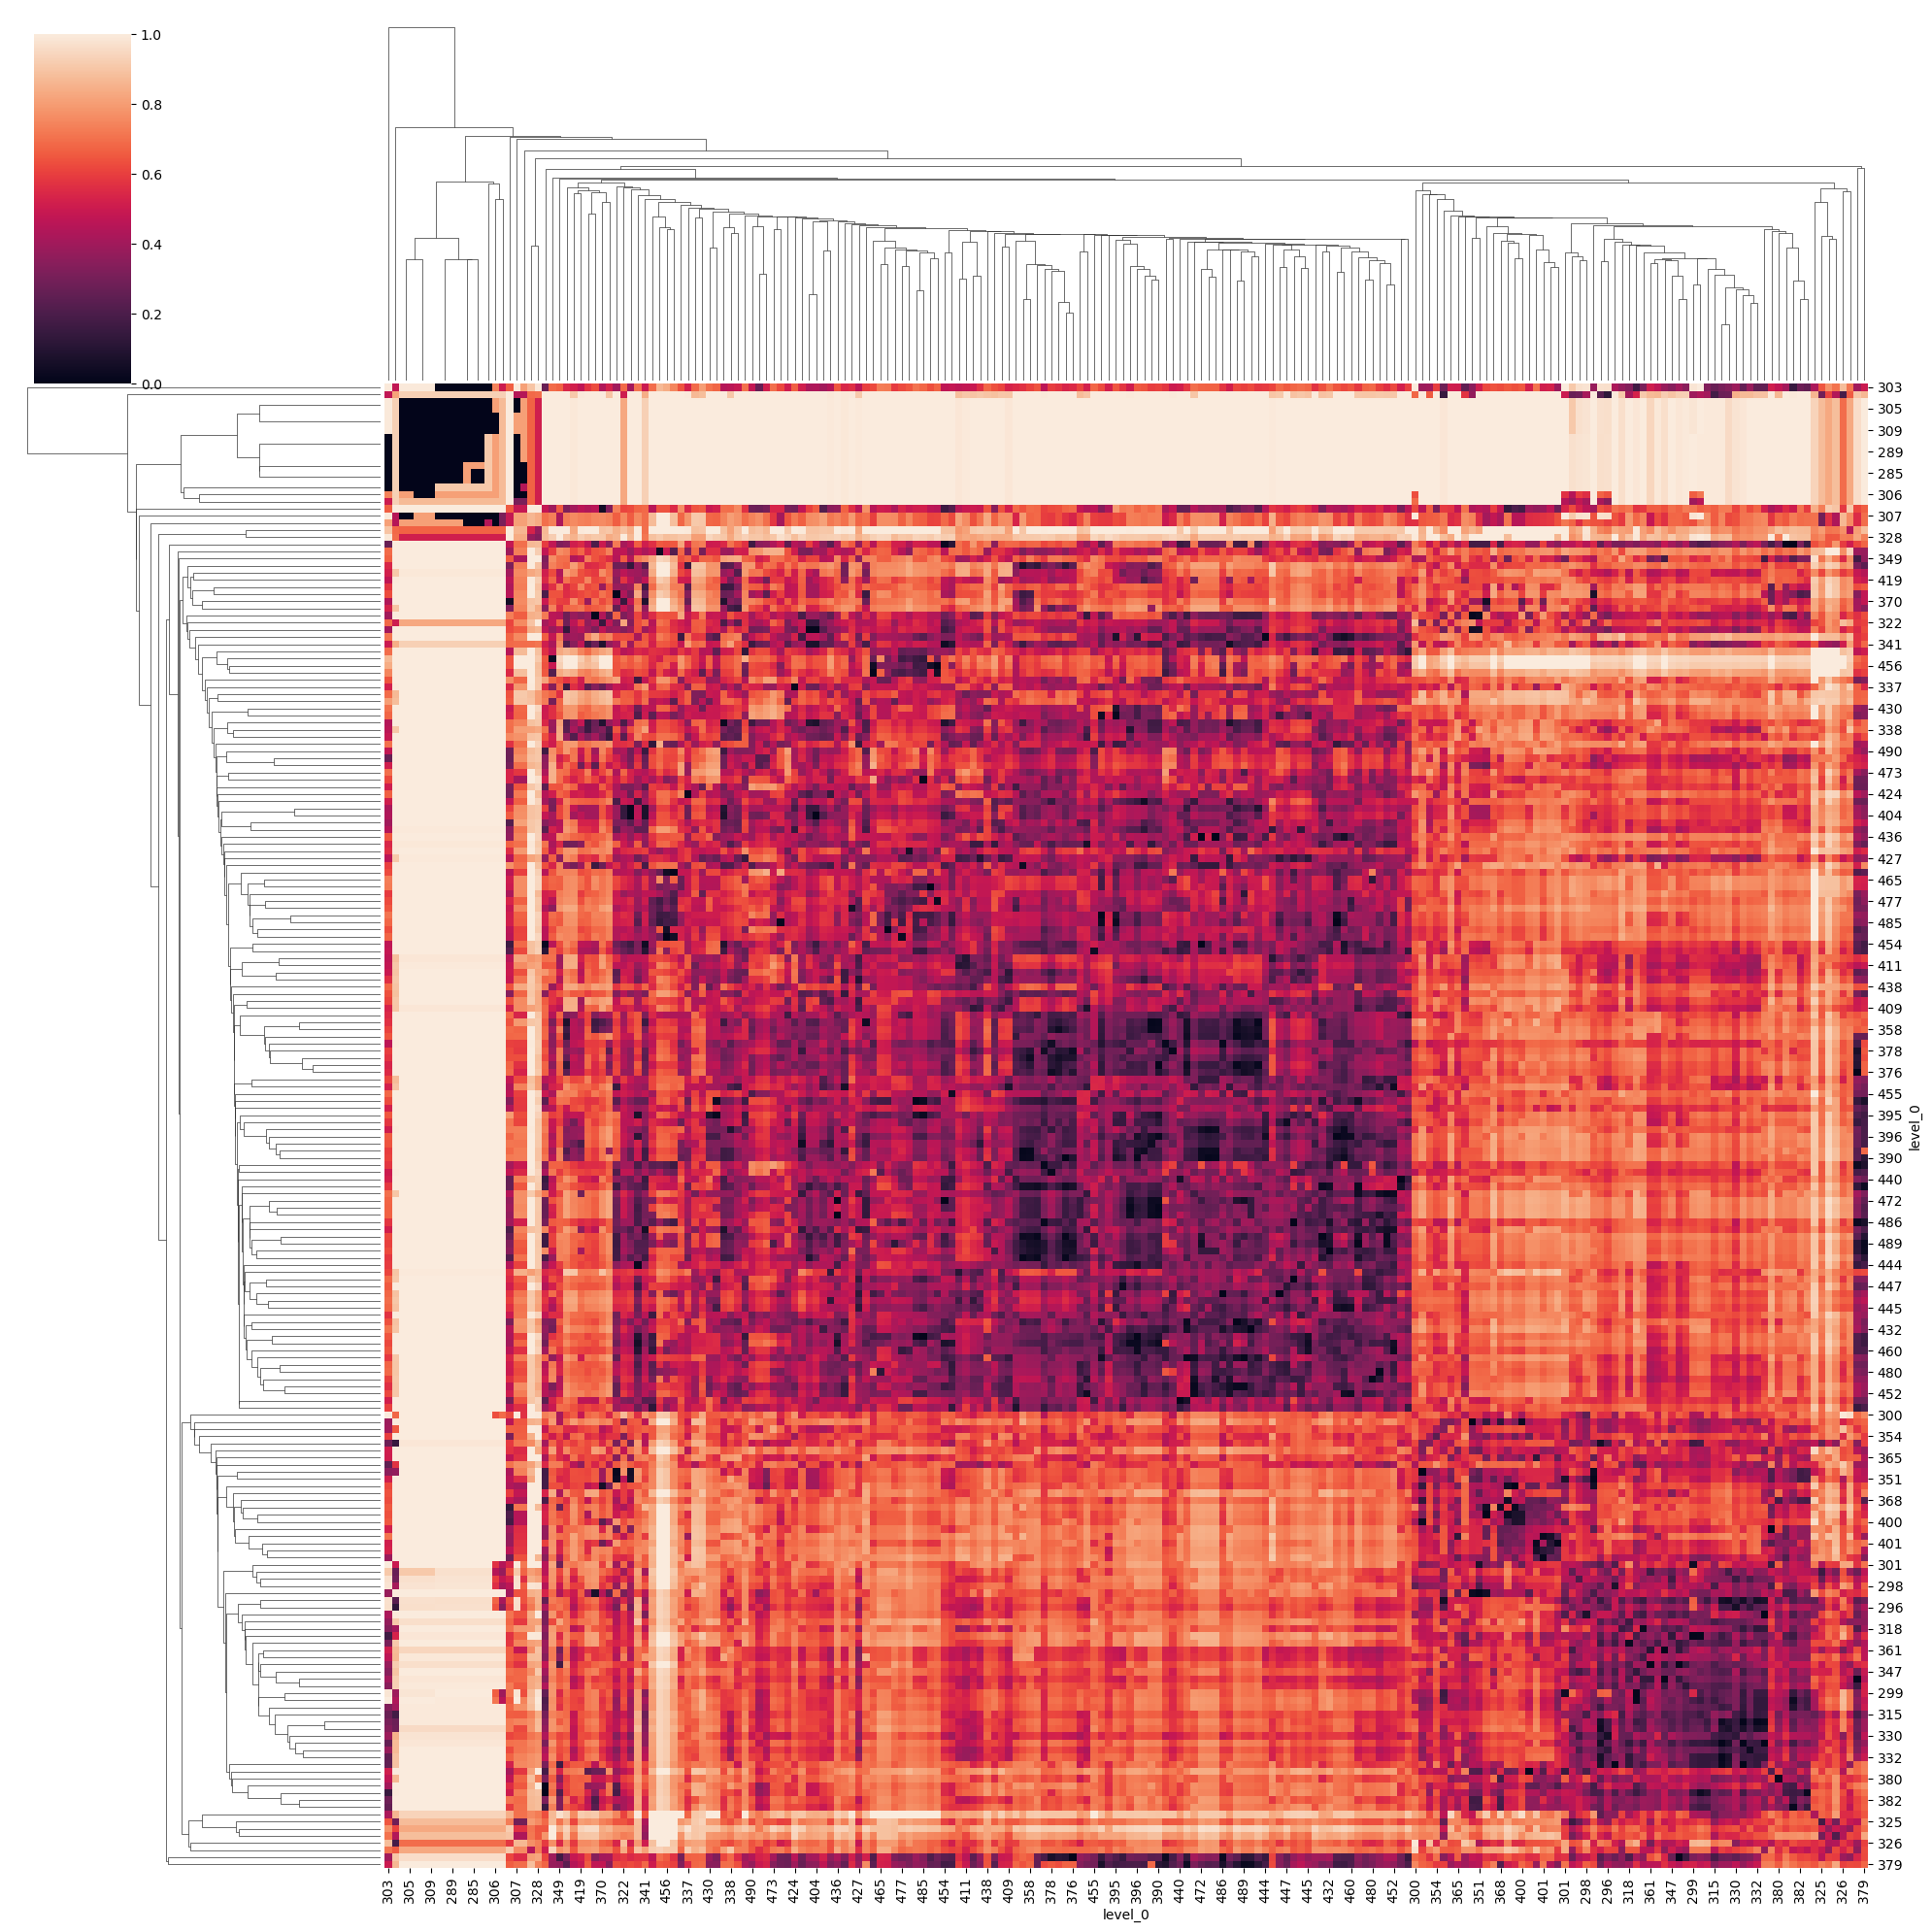

In [455]:
sns.clustermap(nlcd_decomposition_matrix_2,method='single',figsize=(20,20));

In [456]:
Z_2=linkage(nlcd_decomposition_matrix_2, method='single')
c_2, coph_dists_2=cophenet(Z_2, pdist(nlcd_decomposition_matrix_2))
print(c_2)

0.7698283960632706


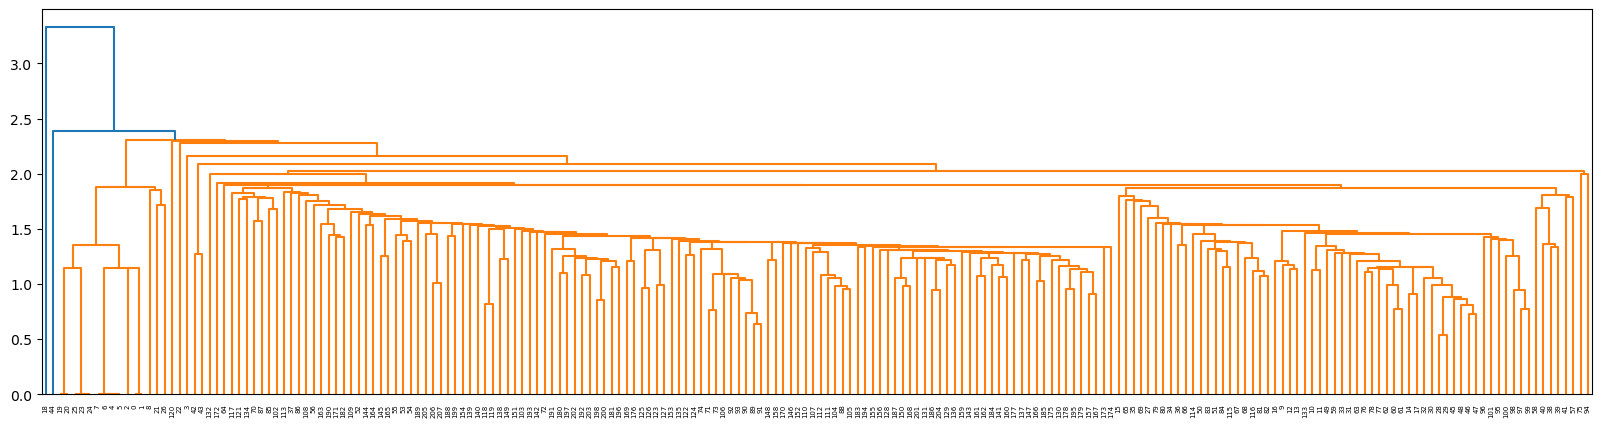

In [457]:
fig=plt.figure(figsize=(20,5))
dendrogram(Z_2)
plt.show()

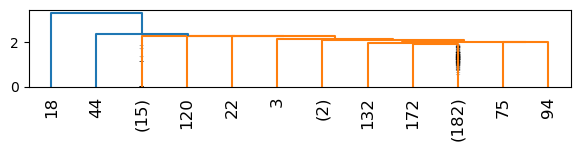

In [458]:
fig=plt.figure(figsize=(7,1))
dendrogram(
    Z_2,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [463]:
quadrat_pts=np.array(quadrats_gdf[285:493].coords.to_list())
quadrat_pts[:5]

array([[-2262093.43904849,  1926411.06361749],
       [-2262093.43904849,  1928411.06361749],
       [-2262093.43904849,  1930411.06361749],
       [-2262093.43904849,  1932411.06361749],
       [-2262093.43904849,  1934411.06361749]])

34


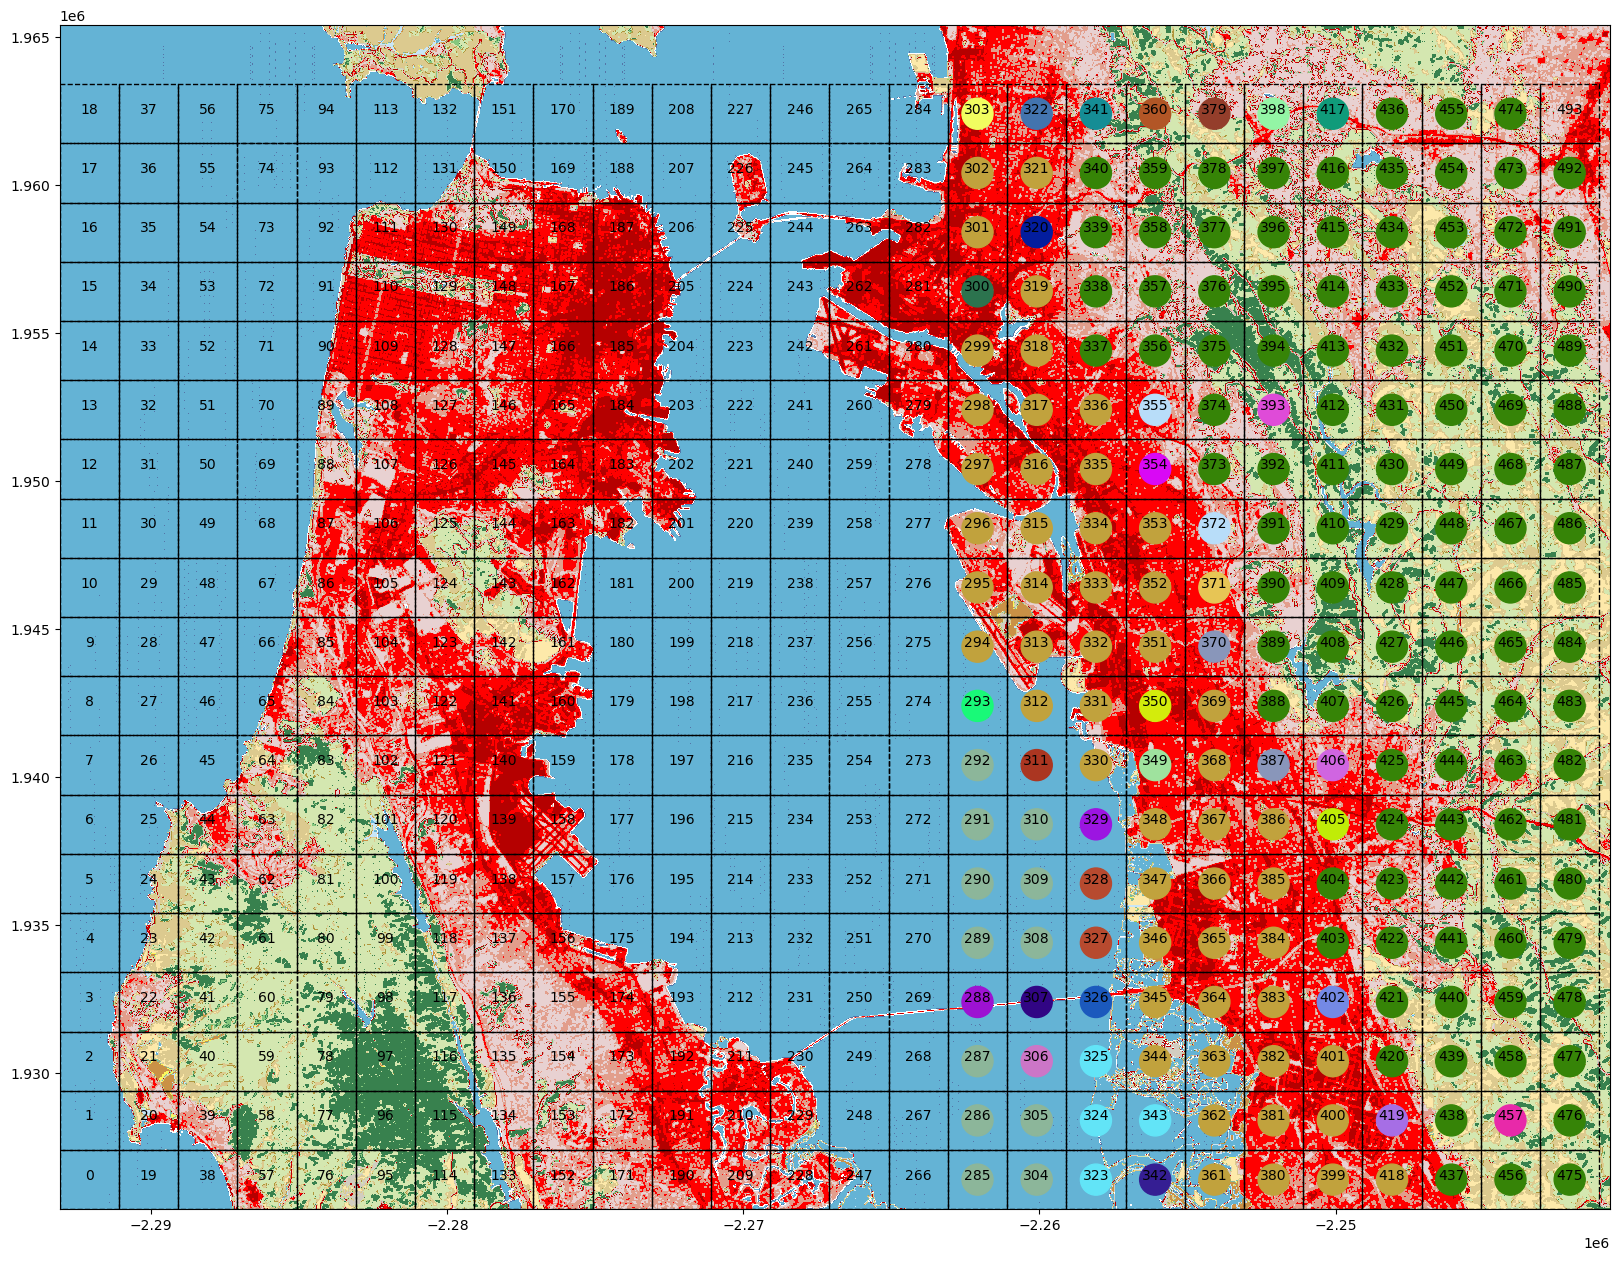

In [473]:
max_d=1.7
clusters=fcluster(Z_2, max_d, criterion='distance')
print(len(np.unique(clusters)))

np.random.seed(0)
cmap=matplotlib.colors.ListedColormap (np.random.rand(256,3))

f, ax=plt.subplots(figsize=(20,20))
show(lu,ax=ax,transform=transform,cmap=cmap_LC,norm=norm)
quadrats_gdf.plot(color='none',edgecolor='k',linewidth=1,ax=ax,linestyle='--')
for idx, row in quadrats_gdf.iterrows():    
    ax.annotate(text=idx, xy=row['coords'], horizontalalignment='center')
ax.scatter(quadrat_pts[:,0], quadrat_pts[:,1], c=clusters, cmap=cmap,s=500)
plt.show()

### 3.5.4.2 模式搜索 

### 3.5.4.3 模式监测

### 3.5.4.4 模式分割